# This notebook explores the anomaly detection problem

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
from scipy.cluster.hierarchy import dendrogram, linkage

# Read in the data, label it choose an engine number to examine

In [2]:

data = pd.read_csv('data/train_FD001.txt',header=None,delim_whitespace=True)

# Now we label the columns
#cols =['engine_num','time_cycles']
settings = ['operational_setting_1','operational_setting_2','operational_setting_3']
sensors = ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8',
           'sensor_9','sensor_10', 'sensor_11','sensor_12', 'sensor_13','sensor_14', 'sensor_15','sensor_16',
           'sensor_17','sensor_18', 'sensor_19','sensor_20', 'sensor_21']

cols = ['engine_num','time_cycles']+settings+sensors
data.columns = cols


sensor_data = data.drop(settings,axis=1)
sensor_data = sensor_data[sensor_data['engine_num']==63]
sensor_data = sensor_data[sensors]


# Remove the sensor data (1,18,19)

## We then examine the correlation of the other sensors 

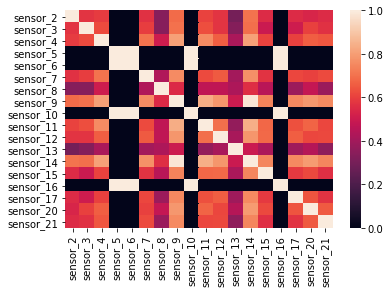

In [3]:
# Now we examine the correlations 
eng1_data = sensor_data

# These three sensors are flat lines
eng1_data = eng1_data.drop(["sensor_1"], axis=1)
eng1_data = eng1_data.drop(["sensor_18"], axis=1)
eng1_data = eng1_data.drop(["sensor_19"], axis=1)

corr = eng1_data.corr()
corr = np.abs(corr)

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# Now we remove the sensors that are constant

## This type of sensor data manifests as a high correlation value. All of these sensors are constant

## Remove sensors (5,6,10,16) and examine resulting data set. These values are all constant settings.

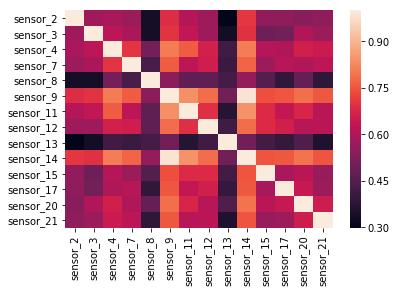

In [4]:
# Now we examine the correlations 
eng1_data = sensor_data

# These three sensors are flat lines
eng1_data = eng1_data.drop(["sensor_1"], axis=1)
eng1_data = eng1_data.drop(["sensor_18"], axis=1)
eng1_data = eng1_data.drop(["sensor_19"], axis=1)

# Drop these correlated sensors
eng1_data = eng1_data.drop(["sensor_5"], axis=1)
eng1_data = eng1_data.drop(["sensor_6"], axis=1)
eng1_data = eng1_data.drop(["sensor_10"], axis=1)
eng1_data = eng1_data.drop(["sensor_16"], axis=1)
corr = np.abs(eng1_data.corr())

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

# Next, we use hierarchical clustering to group the sensors according to their correlations score

## 1. Once they are clustered, split the groups into three clusters
## 2. Choose one representative sensor from each of the clusters

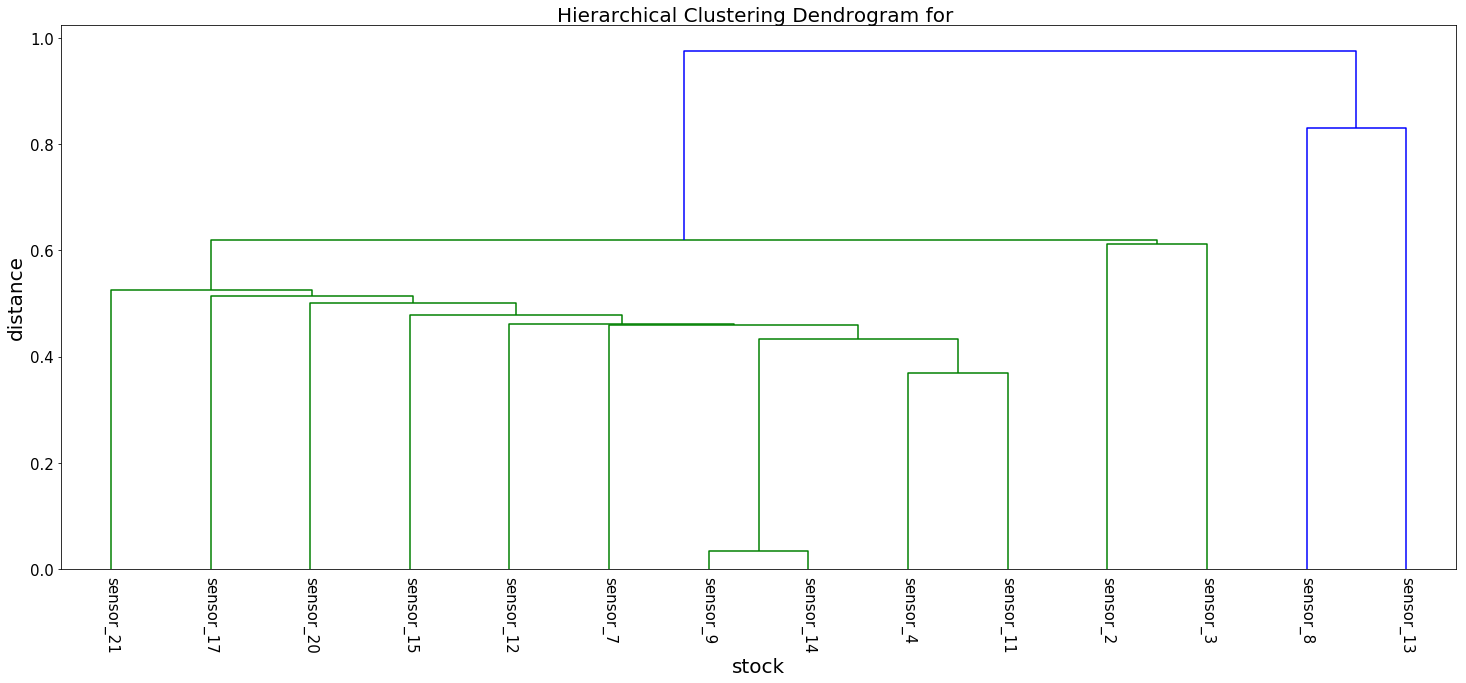

[2, 0, 1]
['sensor_2', 'sensor_4', 'sensor_8']


In [5]:

N_clusters =3 
N_ind_sensors_label = []
N_ind_sensors_name = [] 

corr = np.abs(eng1_data.corr())
M = np.asarray(corr.iloc[:,:])
Z = linkage(M,'single' )
plt.figure(figsize=(25, 10))
labelsize=20
ticksize=15
plt.title('Hierarchical Clustering Dendrogram for ', fontsize=labelsize)
plt.xlabel('stock', fontsize=labelsize)
plt.ylabel('distance', fontsize=labelsize)
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    labels = corr.columns
)
plt.yticks(fontsize=ticksize)
plt.xticks(rotation=-90, fontsize=ticksize)
plt.show()

# Lets generate three clusters based on the data
agglo = cluster.FeatureAgglomeration(n_clusters=N_clusters)
agglo.fit(M)
M_reduced = agglo.transform(M)

cluster_label = agglo.labels_
data_col = corr.columns


# Now we find representatives of the N clusters

# Initialize our array
N_ind_sensors_label.append(cluster_label[0])
N_ind_sensors_name.append(data_col[0])

for k in range(1,len(cluster_label)):
    
    if(cluster_label[k] not in N_ind_sensors_label):
        N_ind_sensors_label.append(cluster_label[k])
        N_ind_sensors_name.append(data_col[k])
        

print(N_ind_sensors_label)
print(N_ind_sensors_name)

# Generate a plot of the chosen clusters

          sensor_2  sensor_4  sensor_8
sensor_2  1.000000  0.590794  0.337201
sensor_4  0.590794  1.000000  0.507146
sensor_8  0.337201  0.507146  1.000000


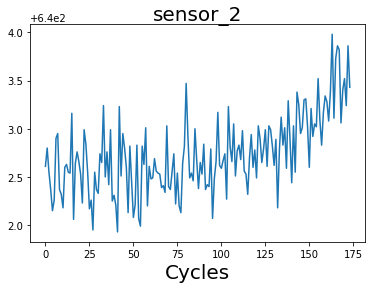

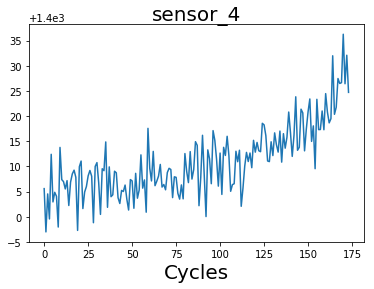

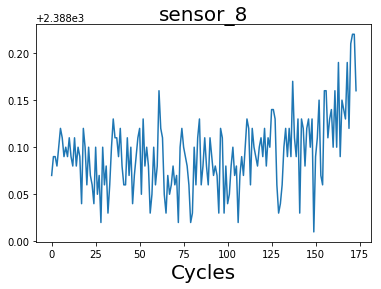

In [6]:
# Now we examine the correlations 
eng1_data_ind = sensor_data[N_ind_sensors_name]
corr = np.abs(eng1_data_ind.corr())

print(corr)

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)


for k in range(len(N_ind_sensors_name)):
    plt.clf()
    plt.title(N_ind_sensors_name[k],size=20)
    plt.xlabel("Cycles",size=20)
    plt.plot(eng1_data_ind.iloc[:,k].values)
    plt.show()

# With the three clusters, we now choose to generate some features for the data set

In [7]:
# Now that we have chosen the sensors, lets compute all of the features


def rms(y):
    
    s = np.dot(y,y)
    s = s/float(len(y))
    s =np.sqrt(s)
    
    return s

def max_peak(y):
    
    s = np.max(y)
    
    return s

def line_int(y):
    
    s = 0.0
    
    for i in range(1,len(y)):
        s+= np.abs(y[i]-y[i-1])
    
    return s

def energy(y):
    
    y = y -np.mean(y)
    s = np.dot(y,y)
    
    return s

def std(y):
    
    s = np.std(y)
    
    return s

def compute_property(func,y_vec):
    
    N = len(y_vec)
    y_func = np.zeros(N)
    
    for i in range(1,N+1):
        yi = y_vec[0:i]
        fi = func(yi)
        y_func[i-1] = fi
    
    
    
    return y_func
    




# Next, we compute all features for all of the sensors and combine all of the data into a large feature matrix

In [8]:
from sklearn.preprocessing import StandardScaler

# Generate a new data frame with all of these new features
X =  pd.DataFrame()

energy_set = ['energy_'+str(int(k)) for k in range(0,N_clusters)]
rms_set = ['rms_'+str(int(k)) for k in range(0,N_clusters)]
line_set = ['line_'+str(int(k)) for k in range(0,N_clusters)]
max_set = ['max_'+str(int(k)) for k in range(0,N_clusters)]
std_set = ['std_'+str(int(k)) for k in range(0,N_clusters)]

for k in range(len(energy_set)):
    feature_name_1 = energy_set[k]
    feature_name_2 = rms_set[k]
    feature_name_3 = line_set[k]
    feature_name_4 = max_set[k]
    feature_name_5 = std_set[k]
    X[feature_name_1] = compute_property(energy, eng1_data_ind.iloc[0:,k].values)
    X[feature_name_2] = compute_property(rms, eng1_data_ind.iloc[0:,k].values)
    X[feature_name_3] = compute_property(line_int, eng1_data_ind.iloc[0:,k].values)
    X[feature_name_4] = compute_property(max_peak, eng1_data_ind.iloc[0:,k].values)
    X[feature_name_5] = compute_property(std, eng1_data_ind.iloc[0:,k].values)


all_features = energy_set+rms_set+line_set+max_set+std_set



# The feature matrix has high dimensionality, use PCA to find the first two Priciple components of the feature matrix

Explained Varaince:  [0.78080899 0.11179128]


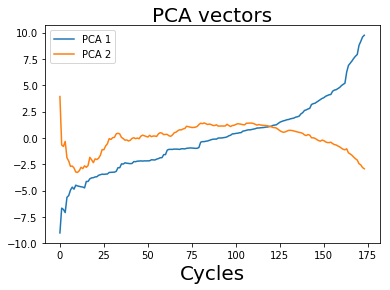

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

# Scale all of the features 
X = X.loc[:, all_features].values
X = StandardScaler().fit_transform(X)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])

print('Explained Varaince: ', pca.explained_variance_ratio_)

V1 = principalDf['pc1']
V2 = principalDf['pc2']

plt.title("PCA vectors",size=20)
plt.plot(V1,label="PCA 1")
plt.plot(V2,label="PCA 2")
plt.xlabel("Cycles",size=20)
plt.legend()
plt.show()

# Next, we define a function that will carry out the Bayesian linear regression and apply the Savgol filter to the PCA vector to smoothen the signal

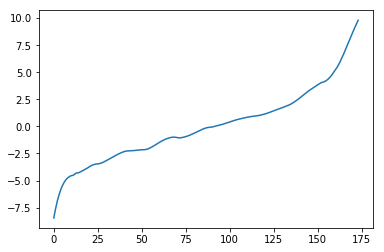

In [19]:
# Now lets make a Bayesian Polynomial fit of the PCA vectors
import emcee
import scipy.optimize as op
from scipy.signal import savgol_filter # This is to smoothen the signal

#savgol_filter(y, 11, 3) # window size 51, polynomial order 3
x = range(len(V1))
y1 = savgol_filter(V1,21,3)
y2 = savgol_filter(V2,21,3)

def bayesian_fit(x,y): 

    def lnlike(theta, x, y):
        a1, b,sigma = theta
        model = a1*x + b
        inv_sigma2 = 1.0/sigma**2
        return -0.5*(np.sum((y-model)**2*inv_sigma2- np.log(inv_sigma2)))

    def lnprob(theta, x, y):
        #lp = lnprior(theta)

        #return lp + lnlike(theta, x, y, yerr)
        return lnlike(theta, x, y)


    nll = lambda *args: -lnlike(*args)
    result = op.minimize(nll, [1.0,1.0,1.0], args=(x, y))
    a1_ml, b_ml, sigma_ml = result["x"]

    ndim, nwalkers = 3, 8
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y))

    sampler.run_mcmc(pos, 100)

    samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
    
    return samples


plt.plot(x,y1)
plt.show()

# From N=0... End, fit Bayesian Line to the PCA vector data, and compute the residual. 

## As the PCA vector deviates from a linear behaviour, the residuals will increase.
## The failure region of the engine will correspond to the region where the size of the residuals is accelerating

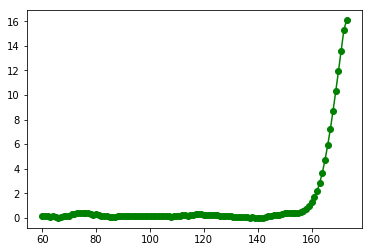

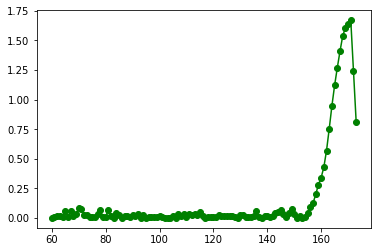

In [11]:
Nk = []
a1_k = []
a2_k = []
a2_error_k = []
a1_error_k = []
sse_k = []

n_min = 60
n_max = len(y1)
steps = 80.0
dh = int(float(n_max-n_min)/float(steps))

for N in range(n_min,n_max,dh):
    
    x_N = x[0:N]
    y_N = y1[0:N]
    
    samples =  bayesian_fit(x_N,y_N)
    
    
    a1_N = np.mean(samples[:,0])
    b_N = np.mean(samples[:,1])
    
    a1_k.append(a1_N)
    
    model_k = b_N + a1_N*np.asarray(x_N)
    sse = np.dot(y_N-model_k,y_N-model_k)
    
    a1_error_k = np.std(samples[:,0])
    sse_k.append(sse)
    Nk.append(N)

    
plt.clf()
sse1_k = np.gradient(sse_k)
plt.plot(Nk,sse1_k,'-o',color='green')
plt.show()    


plt.clf()
sse_k = np.gradient(sse_k)
sse2_k = np.abs(np.gradient(sse_k))
plt.plot(Nk,sse2_k,'-o',color='green')
plt.show()    



# Scale the acceleration data using Standard Scalar, set a threshold to define the anomalous acceleration data.

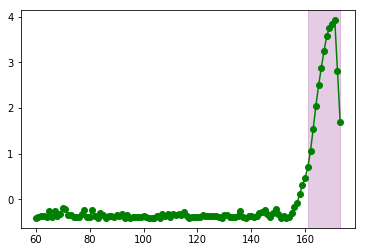

In [20]:
# Now we determine the range of the anomalies
from scipy.signal import argrelextrema
from scipy.signal import chirp, find_peaks, peak_widths
from sklearn.preprocessing import StandardScaler

# Apply the standard Scaler to the SSE-acceleration data
scaler = StandardScaler()
scaler.fit(sse2_k.reshape(-1,1))
sse2_k_scaled = scaler.transform(sse2_k.reshape(-1,1)).flatten()

# Define a possible threshold for the failure region
threshold = 0.5 # In units of sigma
Nk_anom =[]

for i in range(len(sse2_k)):
    
    if(sse2_k_scaled[i] >= threshold):
        Nk_anom.append(Nk[i])

if(len(Nk_anom)!=0):
    plt.axvspan(Nk_anom[0],Nk_anom[-1],alpha=0.2, color='purple')
    plt.plot(Nk,sse2_k_scaled,'-o',color='green')
    plt.show()
    

# Now that the anomalous region has been identified, we plot it onto the original sensor data

/home/javier/anaconda3/envs/pm_2019/lib/python3.5/site-packages/matplotlib/axes/_axes.py:546: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


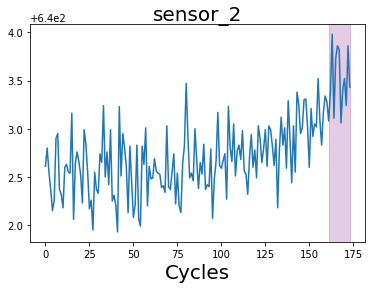

/home/javier/anaconda3/envs/pm_2019/lib/python3.5/site-packages/matplotlib/axes/_axes.py:546: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


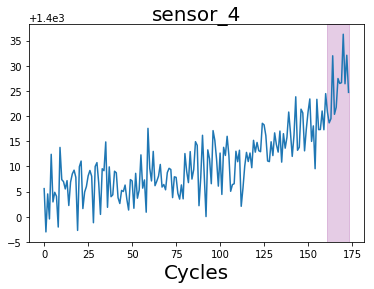

/home/javier/anaconda3/envs/pm_2019/lib/python3.5/site-packages/matplotlib/axes/_axes.py:546: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


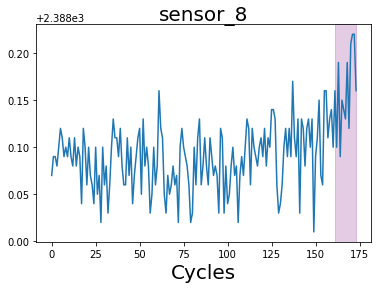

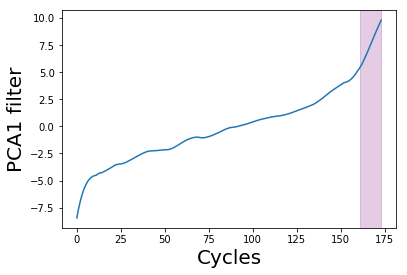

In [17]:
for k in range(0,len(N_ind_sensors_name)):
    plt.clf()
    plt.title(N_ind_sensors_name[k],size='20')
    plt.plot(eng1_data_ind.iloc[:,k].values)
    
    if(len(Nk_anom)!=0):
        plt.axvspan(Nk_anom[0],Nk_anom[-1],alpha=0.2, color='purple')
    
    plt.xlabel("Cycles",size=20)
    plt.legend()
    plt.show()
    
    
plt.clf()
plt.plot(x,y1)
if(len(Nk_anom)!=0):
    plt.axvspan(Nk_anom[0],Nk_anom[-1],alpha=0.2, color='purple')
plt.ylabel("PCA1 filter",size=20)
plt.xlabel("Cycles",size=20)
plt.show()

73


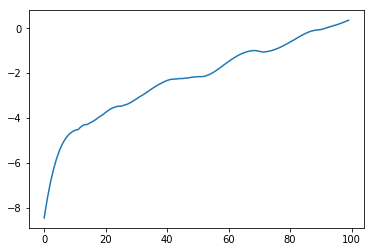

In [18]:
x_feature = y1[0:100]
x_label = x[-1]-x[100]

print(x_label)

plt.plot(x_feature)